In [1]:
import chess
import numpy as np
import random
import chess.svg
import matplotlib.pyplot as plt
from tqdm import tqdm

class FixedChessPuzzleEnvironment:
    def __init__(self):
        self.board = chess.Board()
        self.setup_puzzle()

    def setup_puzzle(self):
        # Clear the board and set up a fixed puzzle with more pieces
        self.board.clear()
        # White pieces
        self.board.set_piece_at(chess.E1, chess.Piece(chess.KING, chess.WHITE))
        self.board.set_piece_at(chess.D5, chess.Piece(chess.QUEEN, chess.WHITE))
        self.board.set_piece_at(chess.H1, chess.Piece(chess.ROOK, chess.WHITE))
        self.board.set_piece_at(chess.C2, chess.Piece(chess.PAWN, chess.WHITE))
        # Black pieces
        self.board.set_piece_at(chess.E8, chess.Piece(chess.KING, chess.BLACK))
        self.board.set_piece_at(chess.D7, chess.Piece(chess.QUEEN, chess.BLACK))
        self.board.set_piece_at(chess.A8, chess.Piece(chess.ROOK, chess.BLACK))
        self.board.set_piece_at(chess.F7, chess.Piece(chess.PAWN, chess.BLACK))
        
    def reset(self):
        self.setup_puzzle()
        return self.get_state()

    def get_state(self):
        # Convert the board state into an 8x8x12 binary tensor
        state = np.zeros((8, 8, 12), dtype=np.int8)
        for i in range(64):
            piece = self.board.piece_at(i)
            if piece:
                state[i // 8, i % 8, piece.piece_type - 1 + (6 if piece.color == chess.BLACK else 0)] = 1
        return state

    def step(self, action):
        try:
            move = self.board.parse_san(action)
            if move in self.board.legal_moves:
                self.board.push(move)
                reward = self.get_reward()
                done = self.board.is_checkmate() or self.board.is_game_over()
                return self.get_state(), reward, done
            else:
                return self.get_state(), -100, False  # Penalize illegal moves
        except ValueError:
            return self.get_state(), -100, False  # Penalize invalid SAN moves
    def get_reward(self):
        if self.board.is_checkmate():
            return 100  # Winning
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            return -50  # Draw
        elif self.board.is_check():
            return 10  # Encouraging checks
        else:
            # Reward based on proximity of attacking pieces to the opponent's king
            white_king_pos = self.board.king(chess.WHITE)
            black_king_pos = self.board.king(chess.BLACK)
            white_queen_pos = next((sq for sq in chess.SQUARES if 
                                    self.board.piece_at(sq) == chess.Piece(chess.QUEEN, chess.WHITE)), None)
            if white_king_pos and black_king_pos and white_queen_pos:
                distance = chess.square_distance(white_queen_pos, black_king_pos)
                return max(-distance / 10.0, -1)  # Penalize greater distances
        return -1  # Default penalty


    def legal_moves(self):
        all_moves = list(self.board.legal_moves)
        filtered_moves = [move for move in all_moves if 
                        self.board.piece_at(move.from_square).piece_type in [chess.KING, chess.QUEEN]]
        return filtered_moves

    
class CEMAgent:
    def __init__(self, env, population_size=500, elite_frac=0.01):
        self.env = env
        self.population_size = population_size
        self.elite_frac = elite_frac

    def select_action(self, state):
        legal_moves = list(self.env.legal_moves())
        if legal_moves:
            move = random.choice(legal_moves)
            return self.env.board.san(move)
        return None

    def select_elite(self, population, rewards):
        elite_count = int(self.population_size * self.elite_frac)
        elite_indices = np.argsort(rewards)[-elite_count:]
        return [population[i] for i in elite_indices]

    def update_policy_distribution(self, elites):
    # Combine elite policies into a single data structure
    # Combine elite policies into a single data structure
        move_counts = {}
        for policy in elites:
            for move in policy:
                if move in move_counts:
                    move_counts[move] += 1
                else:
                    move_counts[move] = 1

        # Normalize the counts to create probabilities
        total_moves = sum(move_counts.values())
        self.policy_distribution = {move: count / total_moves for move, count in move_counts.items()}

    def train(self, episodes=10000):
        for episode in range(episodes):
            population = [self.random_policy() for _ in range(self.population_size)]
            rewards = [self.evaluate_policy(policy) for policy in population]
            elites = self.select_elite(population, rewards)
            self.update_policy_distribution(elites)  # Apply distribution updates

    def random_policy(self):
        moves = []
        while not self.env.board.is_game_over():
            move = np.random.choice(self.env.legal_moves())
            moves.append(move)
            _, _, done = self.env.step(move)
            if done:
                break
        return moves

    def evaluate_policy(self, policy):
        total_reward = 0
        state = self.env.reset()
        for action in policy:
            state, reward, done = self.env.step(action)
            total_reward += reward
            if done:
                break
        return total_reward

class TrESAgent:
    def __init__(self, env, population_size=500):
        self.env = env
        self.population_size = population_size

    def select_action(self, state):
        legal_moves = list(self.env.legal_moves())
        if legal_moves:
            move = random.choice(legal_moves)
            return self.env.board.san(move)
        return None

    def mutate_policy(self, policy):
        new_policy = policy.copy()
        mutation_index = np.random.randint(len(new_policy))
        legal_moves = self.env.legal_moves()
        if len(legal_moves) > 0:
            new_policy[mutation_index] = random.choice(legal_moves)
        return new_policy
        
    def apply_trust_region(self, policy, base_policy):
        # Example: Limit mutations to a small subset of moves
        for i in range(len(policy)):
            if np.random.rand() > 0.8:  # 20% chance of mutation
                policy[i] = base_policy[i]
        return policy


    def train(self, episodes=10000):
        population = [self.random_policy() for _ in range(self.population_size)]
        for episode in range(episodes):
            rewards = [self.evaluate_policy(policy) for policy in population]
            best_policy_index = np.argmax(rewards)
            new_population = [
                self.apply_trust_region(self.mutate_policy(population[best_policy_index]), population[best_policy_index])
                for _ in range(self.population_size)
            ]
            population = new_population

    def random_policy(self):
        moves = []
        while not self.env.board.is_game_over():
            move = np.random.choice(self.env.legal_moves())
            moves.append(move)
            _, _, done = self.env.step(move)
            if done:
                break
        return moves

    def evaluate_policy(self, policy):
        total_reward = 0
        state = self.env.reset()
        
        for action in policy:
            state, reward, done = self.env.step(action)
            total_reward += reward
            
            if done:
                break
                
        return total_reward

# Define agents (CEMAgent and TrESAgent) as in your original code

def train_and_evaluate(agent, env, episodes=10000, max_moves=500):
    rewards = []
    for episode in range(episodes):
        total_reward = 0
        state = env.reset()
        moves = 0
        while moves < max_moves:
            action = agent.select_action(state)
            if action is None:
                break
            state, reward, done = env.step(action)
            total_reward += reward
            if done:
                break
            moves += 1
        rewards.append(total_reward)

        if episode % 1000 == 0:
            print(f"Episode {episode}: Total Reward: {total_reward}")

    return rewards

# Moving average function
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


In [2]:
# Initialize environment and agents
env = FixedChessPuzzleEnvironment()
cem_agent = CEMAgent(env, population_size=500, elite_frac=0.01)
tres_agent = TrESAgent(env, population_size=500)

# Train and evaluate agents
print("Training CEM Agent")
cem_rewards = train_and_evaluate(cem_agent, env)

print("\nTraining TrES Agent")
tres_rewards = train_and_evaluate(tres_agent, env)

Training CEM Agent
Episode 0: Total Reward: -211.39999999999998
Episode 1000: Total Reward: -186.6
Episode 2000: Total Reward: -138.8
Episode 3000: Total Reward: -46.70000000000003
Episode 4000: Total Reward: 224.5
Episode 5000: Total Reward: -204.0
Episode 6000: Total Reward: -255.4
Episode 7000: Total Reward: -90.60000000000005
Episode 8000: Total Reward: -97.39999999999999
Episode 9000: Total Reward: -168.3

Training TrES Agent
Episode 0: Total Reward: -240.6
Episode 1000: Total Reward: -72.0
Episode 2000: Total Reward: -91.2
Episode 3000: Total Reward: -121.0
Episode 4000: Total Reward: -93.6
Episode 5000: Total Reward: -112.6
Episode 6000: Total Reward: -185.4
Episode 7000: Total Reward: -264.5
Episode 8000: Total Reward: -220.9
Episode 9000: Total Reward: -196.9


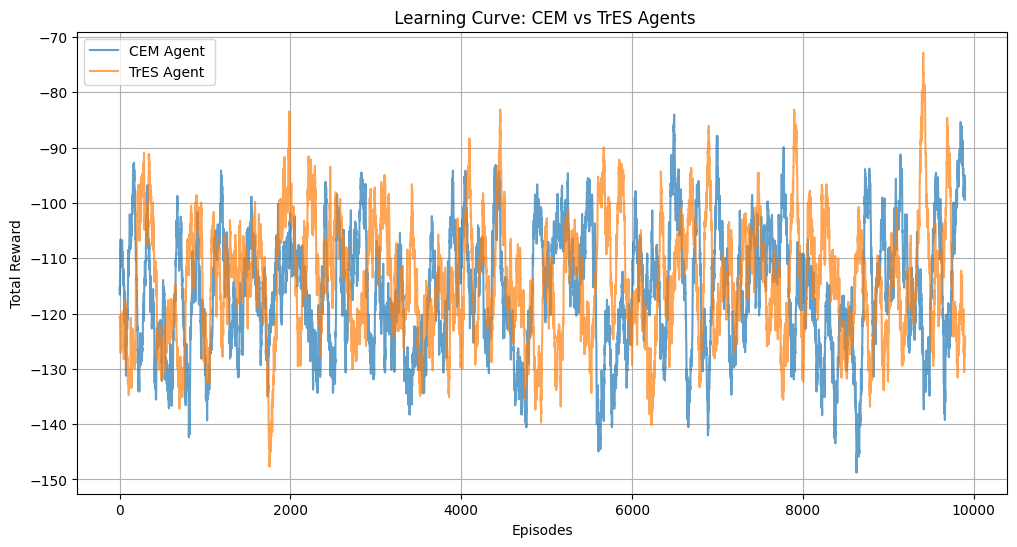

In [3]:
# Smooth rewards
cem_smoothed = moving_average(cem_rewards, window_size=100)
tres_smoothed = moving_average(tres_rewards, window_size=100)


# Plot smoothed learning curve
plt.figure(figsize=(12, 6))
plt.plot(cem_smoothed, label='CEM Agent ', alpha=0.7)
plt.plot(tres_smoothed, label='TrES Agent ', alpha=0.7)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title(' Learning Curve: CEM vs TrES Agents')
plt.legend()
plt.grid()
plt.show()

Evaluating CEM Agent with Population Size: 100
Episode 0: Total Reward: 13.099999999999998
Episode 1000: Total Reward: -80.6
Episode 2000: Total Reward: -8.700000000000003
Episode 3000: Total Reward: -52.80000000000004
Episode 4000: Total Reward: -100.1
Episode 5000: Total Reward: -89.7
Episode 6000: Total Reward: -125.30000000000001
Episode 7000: Total Reward: -67.7
Episode 8000: Total Reward: -103.3
Episode 9000: Total Reward: -297.3
Evaluating TrES Agent with Population Size: 100
Episode 0: Total Reward: 23.999999999999943
Episode 1000: Total Reward: -131.5
Episode 2000: Total Reward: -161.5
Episode 3000: Total Reward: 46.800000000000004
Episode 4000: Total Reward: -93.9
Episode 5000: Total Reward: 47.0
Episode 6000: Total Reward: -209.5
Episode 7000: Total Reward: -1.3000000000000043
Episode 8000: Total Reward: -140.3
Episode 9000: Total Reward: -117.4
Evaluating CEM Agent with Population Size: 500
Episode 0: Total Reward: -288.8
Episode 1000: Total Reward: -253.1
Episode 2000: Tot

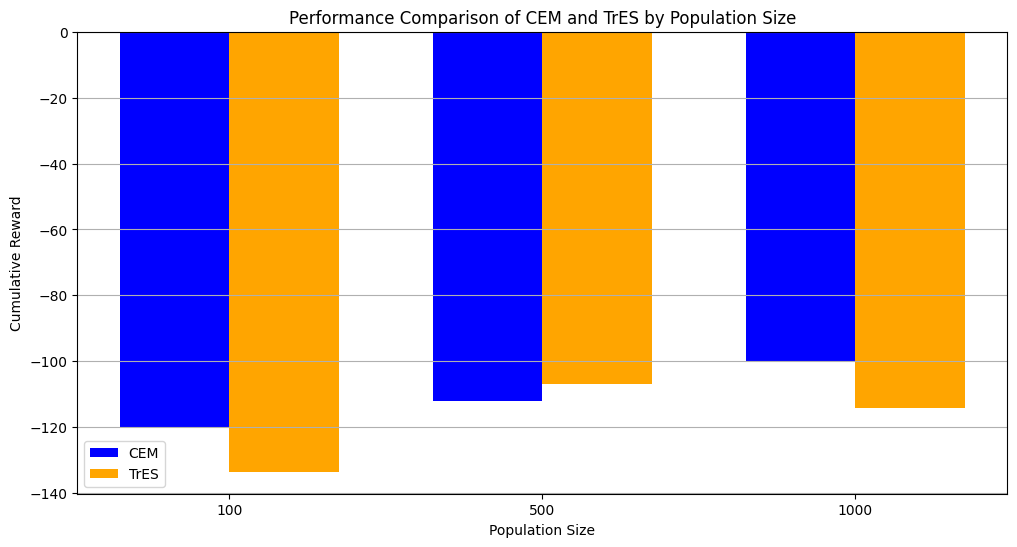

In [5]:
# Function to train agents with different population sizes
def evaluate_population_sizes(env, population_sizes, elite_frac=0.05, episodes=10000):
    cem_results = []
    tres_results = []
    
    for pop_size in population_sizes:
        print(f"Evaluating CEM Agent with Population Size: {pop_size}")
        cem_agent = CEMAgent(env, population_size=pop_size, elite_frac=elite_frac)
        cem_rewards = train_and_evaluate(cem_agent, env, episodes=episodes)
        cem_results.append(np.mean(cem_rewards[-100:]))  # Average reward over last 100 episodes
        
        print(f"Evaluating TrES Agent with Population Size: {pop_size}")
        tres_agent = TrESAgent(env, population_size=pop_size)
        tres_rewards = train_and_evaluate(tres_agent, env, episodes=episodes)
        tres_results.append(np.mean(tres_rewards[-100:]))  # Average reward over last 100 episodes
    
    return cem_results, tres_results

# Define population sizes to test
population_sizes = [100, 500, 1000]

# Evaluate agents with different population sizes
cem_results, tres_results = evaluate_population_sizes(env, population_sizes)

# Plot the results
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(population_sizes))

plt.bar(x - bar_width/2, cem_results, bar_width, label='CEM', color='blue')
plt.bar(x + bar_width/2, tres_results, bar_width, label='TrES', color='orange')

plt.xlabel('Population Size')
plt.ylabel('Cumulative Reward')
plt.title('Performance Comparison of CEM and TrES by Population Size')
plt.xticks(x, labels=[str(size) for size in population_sizes])
plt.legend()
plt.grid(axis='y')
plt.show()
